## 환경설정

### 라이브러리

In [1]:
import os
import random  # DataLoader worker 내부에서만 사용할 예정
import numpy as np

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import mlflow
import mlflow.pytorch



c:\Users\SSAFY\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\protos\service_pb2.py:11: UserWarning: google.protobuf.service module is deprecated. RPC implementations should provide code generator plugins which generate code specific to the RPC implementation. service.py will be removed in Jan 2025
  from google.protobuf import service as _service


In [2]:
# 시각화 안 깨지게
import matplotlib
from matplotlib import font_manager, rc
from PIL import Image

font_path = r"C:\Windows\Fonts\malgun.ttf"  # 또는 "malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False

print("현재 설정된 폰트:", font_name)

현재 설정된 폰트: Malgun Gothic


### MLFlow 설정

In [3]:
data_dir = "../data" 
experiment_name = "resnet_transfer_dataloader"

num_classes = 6
batch_size = 32
num_workers = 0
num_epochs = 5
learning_rate = 1e-3

# MLflow 실험 이름 설정
mlflow.set_experiment(experiment_name)


<Experiment: artifact_location='file:///c:/Users/SSAFY/Downloads/ssafy_1th/AI/notebooks/mlruns/358423444567344628', creation_time=1763448039420, experiment_id='358423444567344628', last_update_time=1763448039420, lifecycle_stage='active', name='resnet_transfer_dataloader', tags={}>

### 난수 설정

In [4]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32  # 각 worker마다 다른 seed
    # np.random.seed(worker_seed)
    random.seed(worker_seed)
    torch.manual_seed(worker_seed)

# DataLoader에서만 사용할 Generator
dataloader_generator = torch.Generator()
dataloader_generator.manual_seed(42)  # DataLoader 전용 seed

### DataLoader 정의

In [5]:
# ImageNet 사전학습 ResNet이 기대하는 정규화 값
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# 증강
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        # 필요하면 RandomHorizontalFlip 등 추가 가능 (data augmentation)
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ]),
}

image_datasets = {
    "train": datasets.ImageFolder(os.path.join(data_dir, "train"), data_transforms["train"]),
    "val": datasets.ImageFolder(os.path.join(data_dir, "val"), data_transforms["val"]),
}

# DataLoader에서만 난수 고정:
# - generator=dataloader_generator
# - worker_init_fn=seed_worker
dataloaders = {
    "train": DataLoader(
        image_datasets["train"],
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        worker_init_fn=seed_worker,
        generator=dataloader_generator,  # DataLoader 전용 Generator
        pin_memory=True
    ),
    "val": DataLoader(    
        image_datasets["val"],
        batch_size=batch_size,
        shuffle=False,  # 일반적으로 검증에는 shuffle=False
        num_workers=num_workers,
        worker_init_fn=seed_worker,
        generator=dataloader_generator,
        pin_memory=True
    ),
}

dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 모델 빌드

In [6]:
# 전이 학습용 모델 정의
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
# model = models.resnet18(pretrained=True)  # 구버전 형태

# 마지막 FC 레이어 교체
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [6]:
# train / validate 함수 정의
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)

    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    # 평가 시 gradient 비활성화
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)

    return epoch_loss, epoch_acc


## 학습


In [16]:
# 학습 실행(MLflow)

with mlflow.start_run(run_name="resnet18_transfer_dataloader_seed_only"):
    # 하이퍼파라미터 로깅
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("num_workers", num_workers)
    mlflow.log_param("dataloader_seed", 2025)

    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(
            model, dataloaders["train"], criterion, optimizer, device
        )
        val_loss, val_acc = evaluate(
            model, dataloaders["val"], criterion, device
        )

        print(
            f"[Epoch {epoch+1}/{num_epochs}] "
            f"train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, "
            f"val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}"
        )

        # MLflow에 metric 로깅 (step=epoch)
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_acc", train_acc, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_acc", val_acc, step=epoch)

        # best model 갱신
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

    # best 모델 저장
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # 모델 아티팩트로 저장
    mlflow.pytorch.log_model(model, artifact_path="model")

    print(f"Best val_acc: {best_val_acc:.4f}")


[Epoch 1/5] train_loss: 0.7245, train_acc: 0.7404, val_loss: 0.9946, val_acc: 0.6467
[Epoch 2/5] train_loss: 0.5106, train_acc: 0.8169, val_loss: 0.7879, val_acc: 0.7000
[Epoch 3/5] train_loss: 0.3817, train_acc: 0.8652, val_loss: 1.1395, val_acc: 0.6033
[Epoch 4/5] train_loss: 0.3291, train_acc: 0.8865, val_loss: 1.3262, val_acc: 0.5717


2025/11/18 16:56:31 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[Epoch 5/5] train_loss: 0.2993, train_acc: 0.8908, val_loss: 0.8484, val_acc: 0.7267


2025/11/18 16:56:37 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torchvision==0.23.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Best val_acc: 0.7267


## 결과확인

## 모델 추론 모드

In [6]:
import mlflow
import mlflow.pytorch
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_id = "d8b7f62c6dd64ce5bc0b3855fcff0991"  # run_id
mlflow.set_tracking_uri("file:./mlruns")

model_path = "./mlruns/358423444567344628/d8b7f62c6dd64ce5bc0b3855fcff0991/artifacts/model"

model = mlflow.pytorch.load_model(model_path)  # 전체 모델 로드
model = model.to(device)
model.eval()  # 추론 모드


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 역정규화 함수 정의

In [7]:
from torchvision import transforms
import matplotlib.pyplot as plt
import torch

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# Normalize의 역연산: (x * std + mean)
inv_mean = [-m / s for m, s in zip(imagenet_mean, imagenet_std)]
inv_std = [1.0 / s for s in imagenet_std]
inv_normalize = transforms.Normalize(mean=inv_mean, std=inv_std)

## 한 배치 뽑아서 예측 + 시각화 + 라벨

In [10]:
def show_classwise_predictions(
    model,
    dataloader,
    class_names,
    device,
    num_images=3,
    top_k=3
):
    model.eval()
    dataset = dataloader.dataset

    rng = np.random.default_rng()
    indices = rng.choice(len(dataset), size=num_images, replace=False)

    fig = plt.figure(figsize=(14, 4 * num_images))

    for i, idx in enumerate(indices):
        img_path, gt_label = dataset.imgs[idx]

        # 이미지 로드
        img = Image.open(img_path).convert("RGB")
        input_tensor = dataset.transform(img).unsqueeze(0).to(device)

        # ---------- Inference ----------
        with torch.no_grad():
            logits = model(input_tensor)                 # [1, C]
            probs = torch.softmax(logits, dim=1)[0]      # [C]

        # ---------- Top-k ----------
        topk_probs, topk_indices = torch.topk(probs, k=top_k)

        # ---------- 시각화용 이미지 ----------
        inv_img = inv_normalize(dataset.transform(img))
        inv_img = inv_img.permute(1, 2, 0).clamp(0, 1).cpu()

        # ---------- (1) 이미지 + Top-k 텍스트 ----------
        ax1 = plt.subplot(num_images, 2, 2 * i + 1)
        ax1.imshow(inv_img)
        ax1.axis("off")

        topk_text = "\n".join([
            f"{class_names[topk_indices[j]]}: {topk_probs[j]:.2f}"
            for j in range(top_k)
        ])

        ax1.set_title(
            f"GT: {class_names[gt_label]}\n\n"
            f"[Top-{top_k} Class-wise Probability]\n{topk_text}"
        )

        # ---------- (2) 전체 class 확률 분포 ----------
        ax2 = plt.subplot(num_images, 2, 2 * i + 2)
        ax2.bar(class_names, probs.cpu().numpy())
        ax2.set_ylim(0, 1)
        ax2.set_ylabel("Probability")
        ax2.set_title("Full Class-wise Probability Distribution")
        ax2.tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()


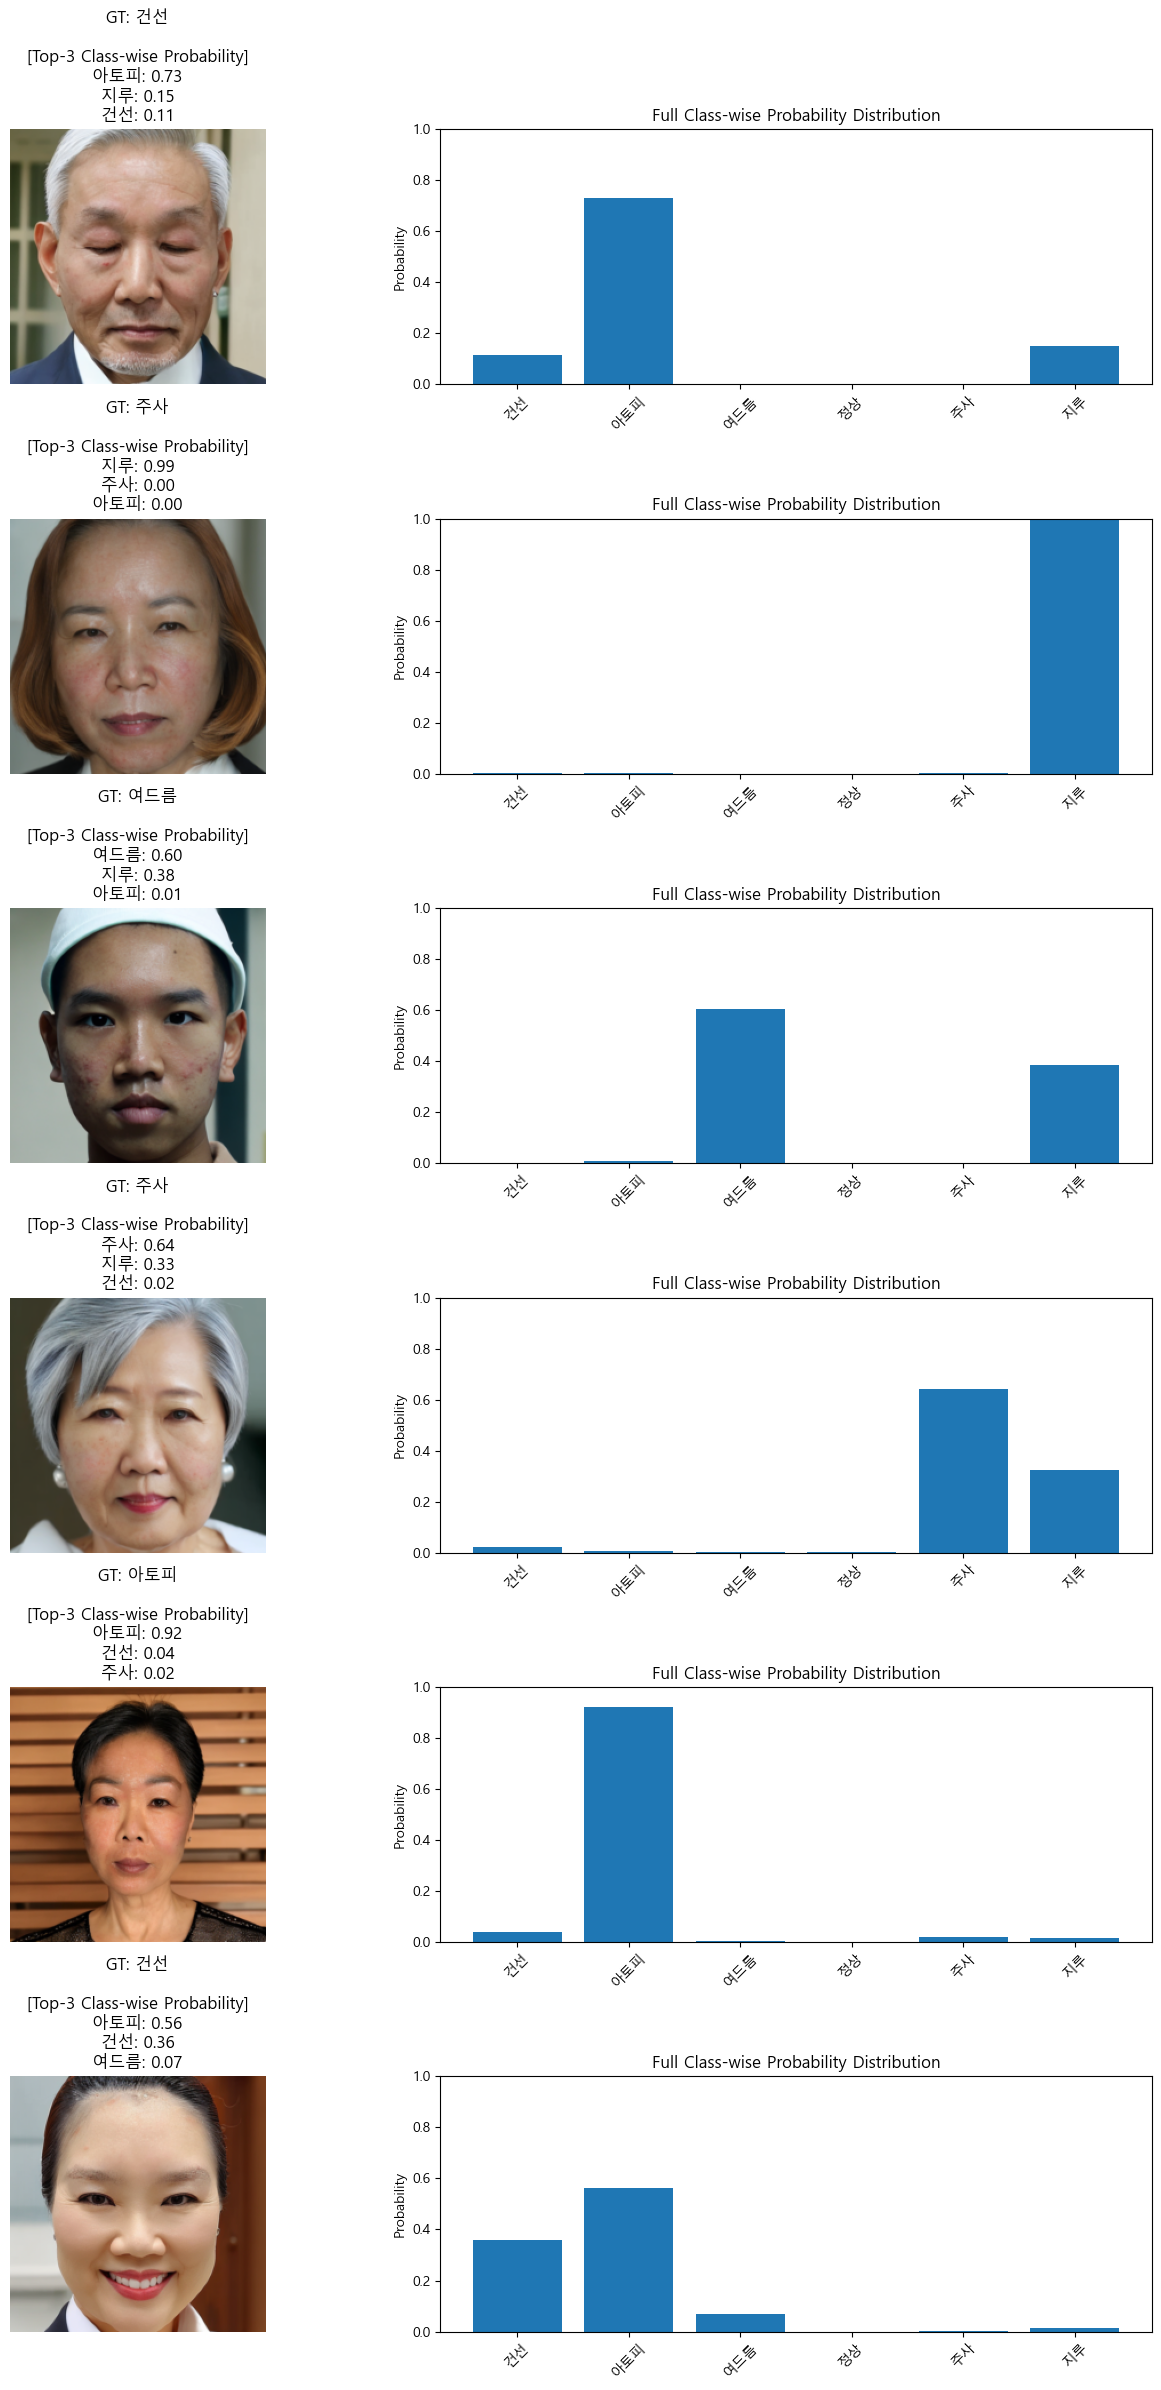

In [11]:
show_classwise_predictions(
    model,
    dataloaders["val"],  # 검증셋 기준으로 보기
    class_names,         # ImageFolder의 클래스 이름 리스트
    device,
    num_images=6
)